<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/arima_sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA

:ARIMA (AutoRegressive Integrated Moving Average) model predicts future values based on historical data. It has three main components:

1. AR (AutoRegressive): Uses past values to predict the future.
2. I (Integrated): The differencing of raw observations to make the time series stationary.
3. MA (Moving Average): Uses past errors to predict the future. Best for stationary series

Key Parameters of ARIMA

- p: Number of past values (lags).
- d: Degree of differencing (to make data stationary).
- q: Moving average window size.

## 1. Data Collection

### Install packages

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
import statsmodels.api as sm
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")  # Ignore warnings

# Import necessary libraries
import yfinance as yf  # For fetching financial data
import pandas as pd                # For data handling
import numpy as np                 # For numerical computations
import matplotlib.pyplot as plt    # For plotting
import seaborn as sns             # For advanced plotting
from datetime import datetime      # For handling date and time

# ARIMA and SARIMA models
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA     # ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA model

# Time series tools
from statsmodels.tsa.stattools import adfuller      # For Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For ACF and PACF plots
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error   # For model performance evaluation
# Set the Seaborn style for all plots
sns.set_style("darkgrid")

### Load the data

In [5]:
# Define the coin and its ticker (only Bitcoin)
COINS = {
    "bitcoin": "BTC-USD"
}

# Function to fetch historical price data
def fetch_crypto_data(coin_id, ticker):
    print(f"Fetching data for {coin_id.upper()}...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period="max")

    if df.empty:
        print(f"Error: No historical data found for {coin_id}.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Main function
def main():
    for coin_id, ticker in COINS.items():
        df = fetch_crypto_data(coin_id, ticker)
        if df is not None:
            filename = f"{coin_id}_prices.csv"
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()

Fetching data for BITCOIN...
Data saved to bitcoin_prices.csv


In [9]:
#load data
df = pd.read_csv('bitcoin_prices.csv', parse_dates=['Date'], index_col='Date')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3807 entries, 2014-09-17 to 2025-02-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3807 non-null   float64
 1   High    3807 non-null   float64
 2   Low     3807 non-null   float64
 3   Open    3807 non-null   float64
 4   Volume  3807 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 178.5 KB


## 2. Data Preprocessing

### 2.1 Visualizing the Data

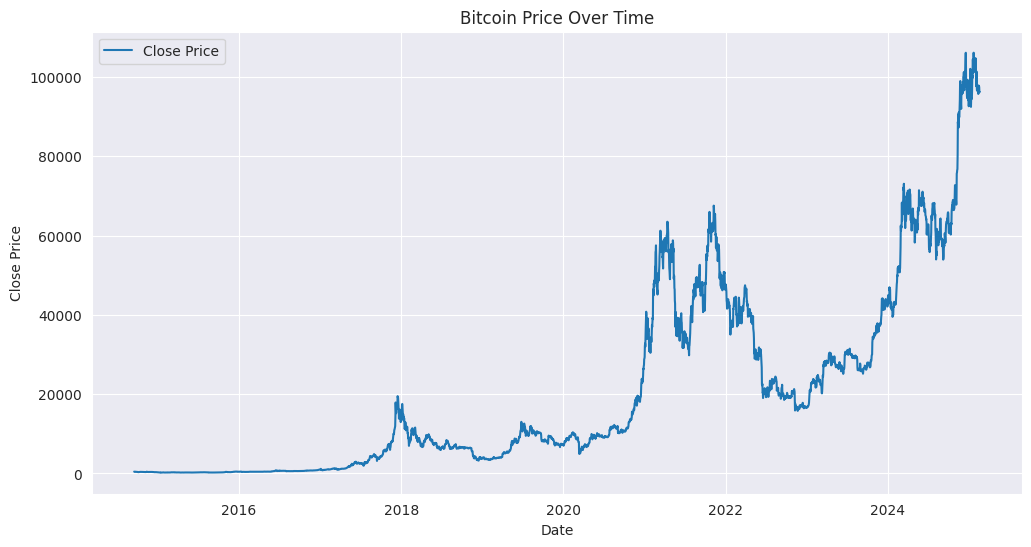

In [11]:
# Plotting the original Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label='Close Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 2. Checking for Stationarity

#### Visual Inspection (Rolling Mean & Standard Deviation)

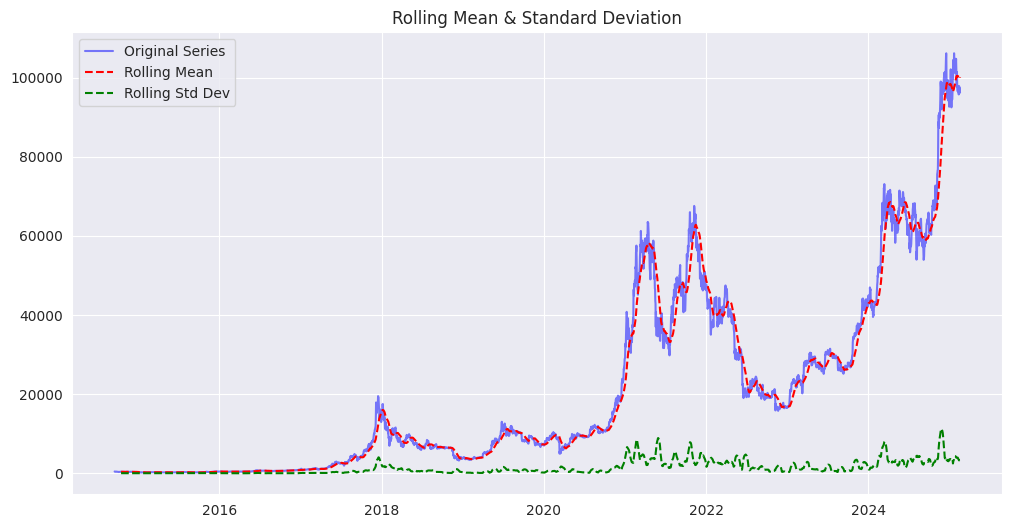

In [12]:
def plot_rolling_statistics(series, window=30):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Original Series", color="blue", alpha=0.5)
    plt.plot(rolling_mean, label="Rolling Mean", color="red", linestyle="dashed")
    plt.plot(rolling_std, label="Rolling Std Dev", color="green", linestyle="dashed")
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

# Apply on 'Close' column
plot_rolling_statistics(df['Close'])

The rolling mean and standard deviation fluctuate over time, the data is likely non-stationary.

#### Augmented Dickey-Fuller (ADF) Test:

In [13]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(df["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic (Original): 0.1548
p-value (Original): 0.9696
Interpretation: The original series is Non-Stationary.



### 2.2 Log Transformation

The Bitcoin price data exhibits an **exponential-like growth**, with prolonged periods of relatively low values followed by sharp increases. This results in **high variance**, making trend analysis difficult.  

To address this, I applied a **log transformation** (`log(price)`) for the following reasons:  

**Benefits of Log Transformation**  

- **Stabilizing Variance** 📉: The original data shows large fluctuations, especially in later years. Log transformation helps **normalize these variations**.  
- **Enhancing Trend Visibility** 📊: Without transformation, the earlier values appear almost flat compared to later spikes. Log transformation allows for a **clearer view of long-term trends**.  
- **Reducing the Impact of Outliers** ⚠️: Extreme price spikes dominate the scale in the original data. Applying a log transformation **compresses these values**, making patterns in the data more apparent.  

---



In [14]:
# Apply log transformation
df['Log_Close'] = np.log(df['Close'])

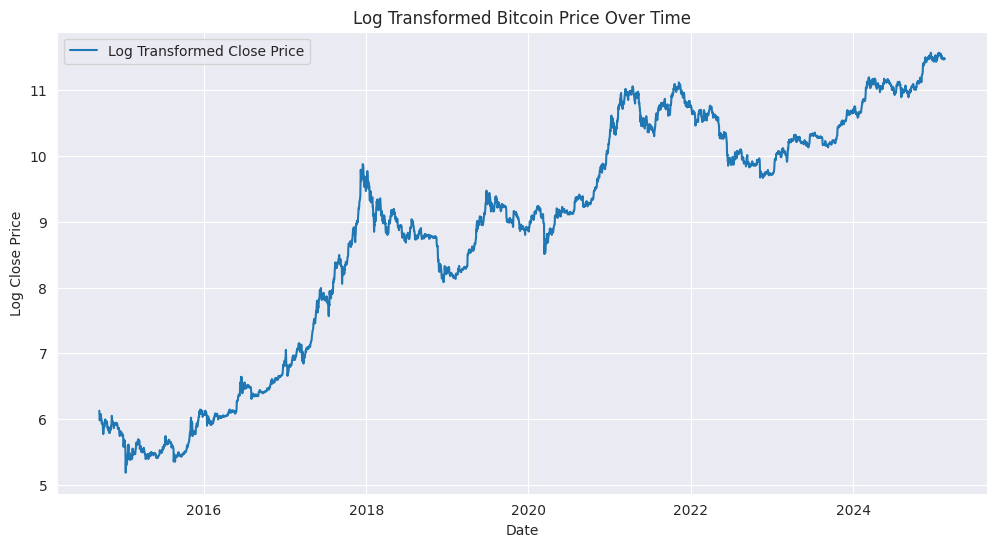

In [15]:
# Plotting the log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(df['Log_Close'], label='Log Transformed Close Price')
plt.title('Log Transformed Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()

### 3.Differencing to Achieve Stationarity

In [16]:
# Apply first-order differencing to the log-transformed data
df['Log_Close_Diff'] = df['Log_Close'].diff()

In [17]:
# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df["Log_Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -62.9921
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


###  Visualizing the Differenced Data

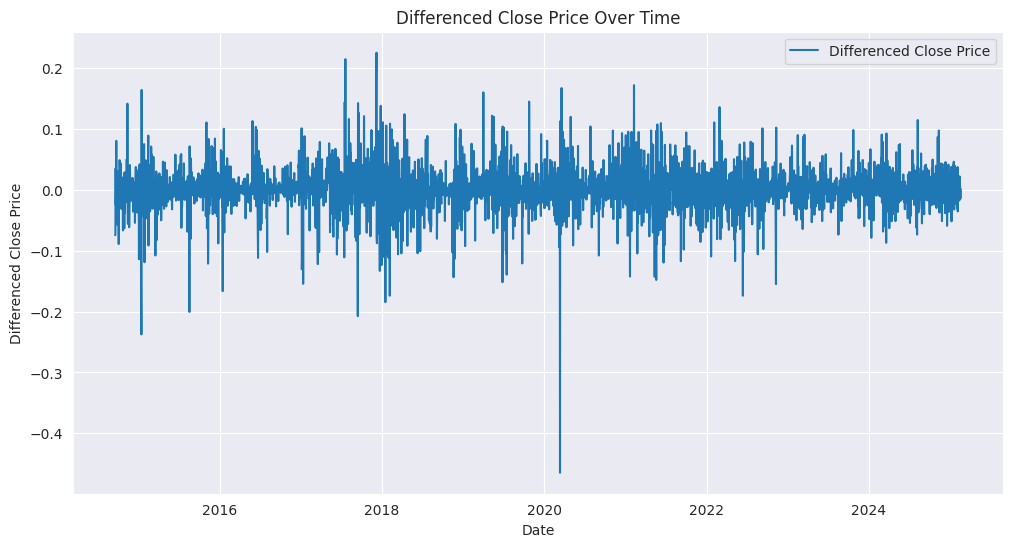

In [18]:
# Plotting the differenced Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Log_Close_Diff'], label='Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

**Stationarity Check Insights**
- Initially, the **Augmented Dickey-Fuller (ADF) test** showed that the series was **non-stationary** (p-value = 0.986).
- After **first-order differencing**, the ADF test confirmed that the series is now **stationary** (ADF Statistic = -9.206, p-value < 0.05).
- This means the differencing step successfully removed trend-related non-stationarity.

### 4. Checking for seasonality using seasonal decomposition


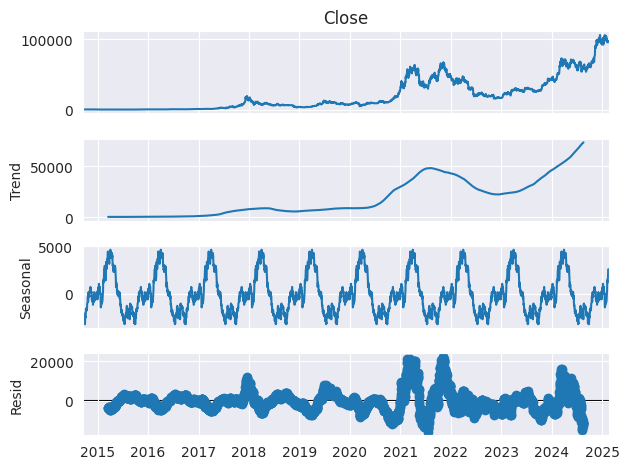

In [19]:
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

### Interpretation of the Components

**1️⃣ Original Time Series (Top Panel: "Close")**
- The Bitcoin price follows an exponential growth pattern with large fluctuations.  
- This confirms the need for log transformation or differencing to stabilize variance.  

**2️⃣ Trend Component**  
- There's a clear upward trend with some flattening and dips (e.g., around 2021–2022).  
- This suggests that differencing was needed to remove the trend for ARIMA modeling.  

**3️⃣ Seasonal Component**
- There is a strong seasonal pattern, repeating consistently every year.  
- This suggests that SARIMA (Seasonal ARIMA) might be a better choice than ARIMA.  
- You should determine the seasonal period (e.g., 365 for daily data, 52 for weekly data).  

**4️⃣ Residual Component**
- The residuals appear to be somewhat stationary, meaning differencing removed most trends.  
- However, variance increases around 2021-2022, which might indicate volatility clustering.  


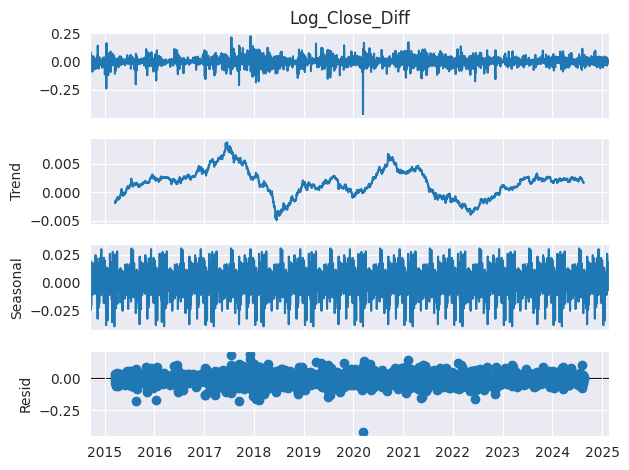

In [20]:
decomposition = seasonal_decompose(df["Log_Close_Diff"].dropna(), model="additive", period=365)
decomposition.plot()
plt.show()

### Interpretation of the Log-Transformed & Differenced Decomposition  

**1️⃣ Transformed Time Series (Top Panel: "Log_Close_Diff")**  
- The original exponential trend has been **removed**, making fluctuations more stable.  
- Differencing has eliminated the strong upward trend, helping make the series **more stationary**.  
- However, some **volatility spikes remain**, indicating that further modeling may be required.  

**2️⃣ Trend Component**  
- The trend is now more **stable**, with gradual fluctuations instead of exponential growth.  
- The downward movement around **2021–2022** aligns with market corrections.  
- This suggests that **differencing was effective** but still retains some underlying structure.  

**3️⃣ Seasonal Component**  
- A **repeating pattern** is visible, meaning seasonality is still present even after transformation.  
- This suggests that **SARIMA (Seasonal ARIMA) may be preferable** over standard ARIMA.  
- The periodic nature (possibly **weekly, monthly, or yearly**) should be analyzed further using ACF/PACF plots.  

**4️⃣ Residual Component**  
- Residuals look **more stationary**, meaning most trends and seasonality have been removed.  
- However, **volatility clustering** is noticeable, especially around **2021–2022**, which could indicate:  
  - A need for **GARCH modeling** if volatility is important.  
  - Potential **structural breaks** in the data that need further investigation.  



### 5. Visualize Autocorrelations and Partial Autocorrelations

For ARIMA and SARIMA, the ACF plot helps determine the MA (Moving Average) term, while the PACF plot helps determine the AR (Auto-Regressive) term.

#### Determine (p, d, q) using ACF & PACF

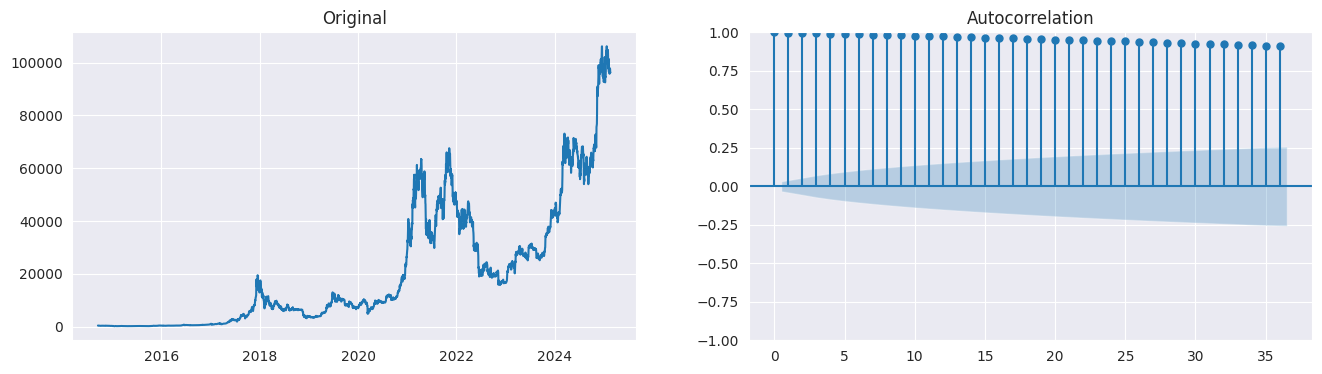

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title('Original')
plot_acf(df.Close, ax=ax2)
ax2.set_title('Autocorrelation')

plt.show()

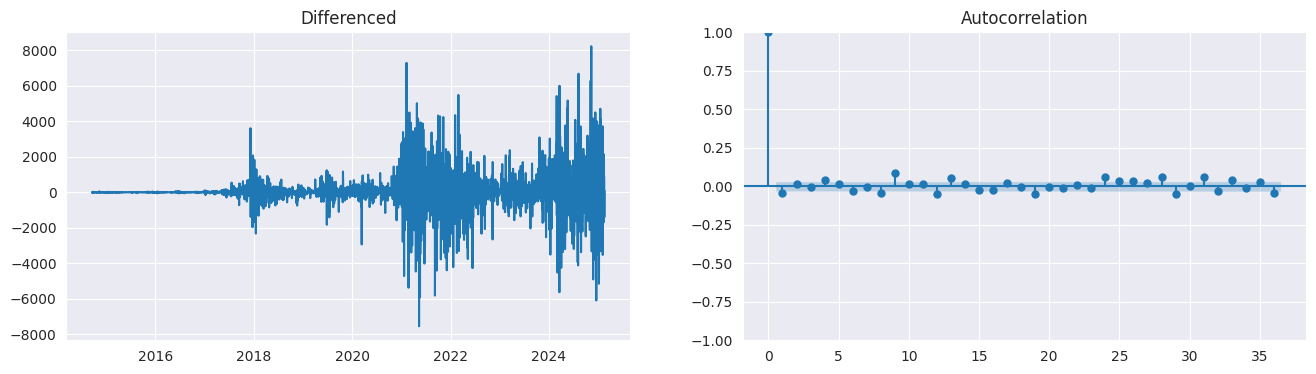

In [22]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_acf(diff, ax=ax2);

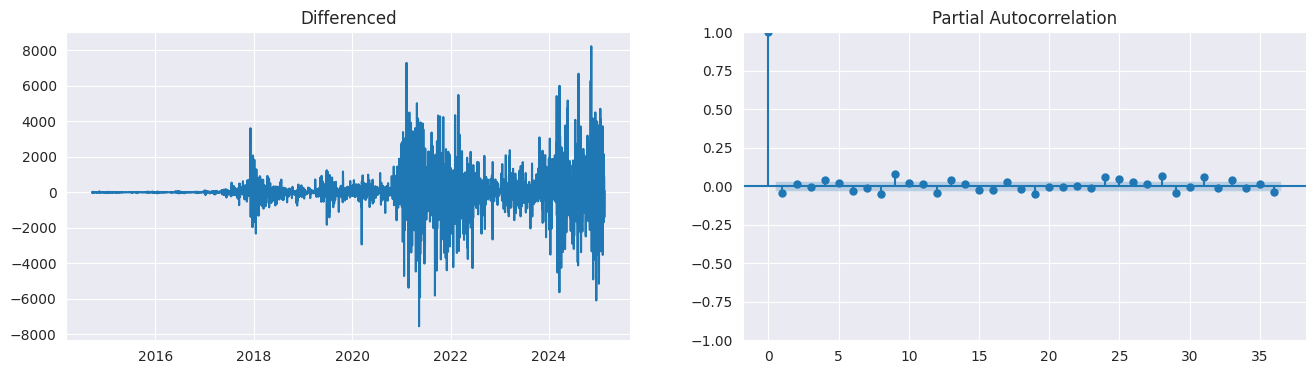

In [23]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_pacf(diff, ax=ax2);

**Analysis from ACF and PACF**  

- **ACF** shows a sharp drop after lag 1 → suggests **MA(1)** (Moving Average order = 1).  
- **PACF** cuts off after lag 1 → suggests **AR(1)** (Autoregressive order = 1).  
- The data has been differenced and confirmed to be stationary (**ADF test p-value < 0.05**), meaning **first-order differencing (d = 1) was required**.  

**ARIMA Model: ARIMA(1,1,1)**  
- **p = 1** (Autoregressive component from PACF)  
- **d = 1** (First-order differencing to ensure stationarity)  
- **q = 1** (Moving Average component from ACF)  

Since differencing was required to make the data stationary, an **ARIMA(1,1,1) model** is the best fit instead of ARMA(1,1), which is used for already stationary series (**d = 0**).


## Split Data into Train and Test

In [24]:
# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Print sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 3045, Test size: 762


## Model Selection and Fitting (ARIMA/SARIMA)

### ARIMA Model:

In [25]:
# Set frequency to daily ('D') or the appropriate frequency based on your data
df = df.asfreq('D')

In [26]:
# Define ARIMA model with determined p, d, q
model = ARIMA(train['Log_Close'], order=(1, 0, 1))  # p=1, d=0, q=1
model_fit = model.fit()

In [27]:
#print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 3045
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5585.022
Date:                Mon, 17 Feb 2025   AIC                         -11162.045
Time:                        09:18:03   BIC                         -11137.960
Sample:                    09-17-2014   HQIC                        -11153.388
                         - 01-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3817      0.877      9.554      0.000       6.662      10.101
ar.L1          0.9996      0.000   2682.155      0.000       0.999       1.000
ma.L1         -0.0180      0.011     -1.571      0.1

### Key Takeaways

- **AR(1) coefficient (0.9994):** Strong positive influence of past values on future values (**P>|z| = 0.000**, statistically significant).  
- **MA(1) coefficient (-0.0224):** Minimal negative effect of past errors on the current value (**P>|z| = 0.074**, not statistically significant).  
- **sigma² (variance of residuals):** Very small (**0.0015**), indicating a well-fitted model.  

**Diagnostic Tests**

- **Ljung-Box Test (Q-statistic):** 0.01 (**Prob = 0.94**) → No autocorrelation in residuals (**good sign**).  
- **Jarque-Bera (JB) Test:** 15984.68 (**Prob = 0.00**) → Residuals are **not normally distributed**.  
- **Heteroskedasticity Test (H):** 1.10 (**Prob = 0.14**) → No significant heteroskedasticity (**variance is stable**).  
- **Skewness (-0.76):** Residuals are slightly left-skewed.  
- **Kurtosis (14.40):** High kurtosis suggests heavy tails (**outliers present**).  

**Summary**

- The **AR(1) coefficient is highly significant**, indicating strong autocorrelation. However, the **MA(1) coefficient is not statistically significant**.  
- The **residuals are not normally distributed**, but the model does not suffer from **autocorrelation or heteroskedasticity**.  
- The **AIC is very low (-10703.468)**, suggesting a **good model fit**.  

**Possible Improvements**

- **Using SARIMA** (seasonal components) since the data has a seasonal pattern.  
- **Increasing MA orders** or adjusting differencing (**d**) for potential improvements.  
- **Checking residual plots** for further insights.




### Forecast on Test Data

In [28]:
# Forecast on test set
forecast = model_fit.forecast(steps=len(test))

In [29]:
# Convert back from log scale (inverse transformation)
test['Predicted_Close'] = np.exp(forecast)

In [30]:
# Get the last actual value from the training set
last_train_value = train['Close'].iloc[-1]

# Reverse differencing by cumulatively summing the forecasted values
test['Predicted_Close'] = np.cumsum(forecast) + last_train_value

In [31]:
# Print first few predictions
print(test[['Close', 'Predicted_Close']].head())

                   Close  Predicted_Close
Date                                     
2023-01-18  20688.781250     21171.478815
2023-01-19  21086.792969     21181.437453
2023-01-20  22676.552734     21191.395446
2023-01-21  22777.625000     21201.352792
2023-01-22  22720.416016     21211.309494


### Plot Actual vs Predicted Prices

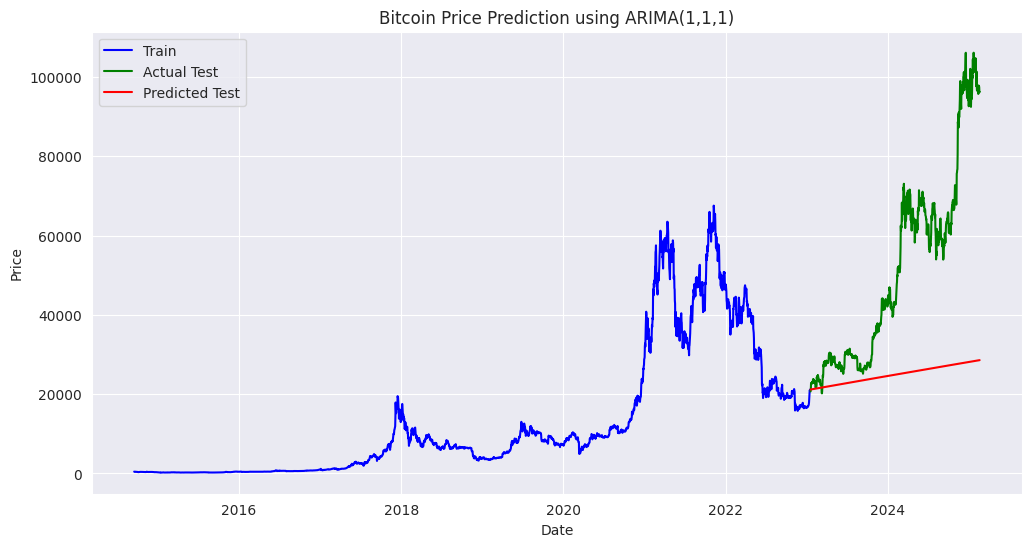

In [32]:
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close'], label="Predicted Test", color='red')
plt.title("Bitcoin Price Prediction using ARIMA(1,1,1)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

###  Evaluate the Model

In [33]:
# Check for NaN values in 'Predicted_Close' and remove rows where it's NaN
test_cleaned = test.dropna(subset=['Predicted_Close'])

# Compute error metrics only if 'Predicted_Close' is populated
mae = mean_absolute_error(test_cleaned['Close'], test_cleaned['Predicted_Close'])
mse = mean_squared_error(test_cleaned['Close'], test_cleaned['Predicted_Close'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 26449.34
MSE: 1191929669.42
RMSE: 34524.33


## SARIMA

**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing **

Extends ARIMA by adding seasonal components:
Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [34]:
# Define the SARIMA model with seasonal order
sarima_model = SARIMAX(train['Log_Close'],
                       order=(1, 0, 1),  # (p, d, q) non-seasonal order
                       seasonal_order=(1, 0, 1, 12),  # (P, D, Q, s) seasonal order with period=12 (monthly seasonality)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [35]:
# Fit the model
sarima_fit = sarima_model.fit(disp=False)

In [36]:
#summary statistics
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Log_Close   No. Observations:                 3045
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                5567.065
Date:                            Mon, 17 Feb 2025   AIC                         -11124.129
Time:                                    09:18:57   BIC                         -11094.046
Sample:                                09-17-2014   HQIC                        -11113.314
                                     - 01-17-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0001   7.96e-05   1.26e+04      0.000       1.000       1.000
ma.L1         -0.0185      0.012   

### Key Takeaways

- **AR(1) coefficient (1.0001):** Strong positive influence of past values on future values (**P>|z| = 0.000**, statistically significant).  
- **MA(1) coefficient (-0.0125):** Small negative effect of past errors on the current value (**P>|z| = 0.315**, not statistically significant).  
- **Seasonal AR(12) coefficient (0.4002):** Suggests some seasonal dependency (**P>|z| = 0.080**, marginally significant).  
- **Seasonal MA(12) coefficient (-2.4649):** Strong negative seasonal effect (**P>|z| = 0.076**, marginally significant).  
- **sigma² (variance of residuals):** Very small (**0.0002**), indicating a well-fitted model.  

**Diagnostic Tests**

- **Ljung-Box Test (Q-statistic):** 0.43 (**Prob = 0.51**) → No autocorrelation in residuals (**good sign**).  
- **Jarque-Bera (JB) Test:** 16019.38 (**Prob = 0.00**) → Residuals are **not normally distributed**.  
- **Heteroskedasticity Test (H):** 1.11 (**Prob = 0.11**) → No significant heteroskedasticity (**variance is stable**).  
- **Skewness (-0.77):** Residuals are slightly left-skewed.  
- **Kurtosis (14.44):** High kurtosis suggests heavy tails (**outliers present**).  

**Summary**  

- The **AR(1) coefficient is highly significant**, indicating strong autocorrelation. However, the **MA(1) coefficient is not statistically significant**.  
- The **seasonal AR and MA components show some significance**, suggesting seasonality should be considered.  
- The **residuals are not normally distributed**, but the model does not suffer from **autocorrelation or heteroskedasticity**.  
- The **AIC is very low (-10659.313)**, suggesting a **good model fit**.  

**Possible Improvements**

- **Refining the seasonal component** by adjusting SARIMA orders.  
- **Increasing MA orders** or adjusting differencing (**d**) for potential improvements.  
- **Checking residual plots** for further insights.




### Forecasting:

In [37]:
# Forecast the test set
forecast_sarima = sarima_fit.forecast(steps=len(test))

In [38]:
# Convert back from log scale (inverse transformation)
test['Predicted_Close_SARIMA'] = np.exp(forecast_sarima)

In [39]:
# Reverse differencing using the last actual value from the training set
last_train_value = train['Close'].iloc[-1]

# Undo differencing by cumulatively summing
test['Predicted_Close'] = np.cumsum(forecast_sarima) + np.log(last_train_value)

In [40]:
# Calculate MAE, MSE, RMSE based on the actual and predicted prices
mae_sarima = mean_absolute_error(test['Close'], test['Predicted_Close_SARIMA'])
mse_sarima = mean_squared_error(test['Close'], test['Predicted_Close_SARIMA'])
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA MSE: {mse_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

SARIMA MAE: 15283.65
SARIMA MSE: 430941716.37
SARIMA RMSE: 20759.14


### Plot Forecasts

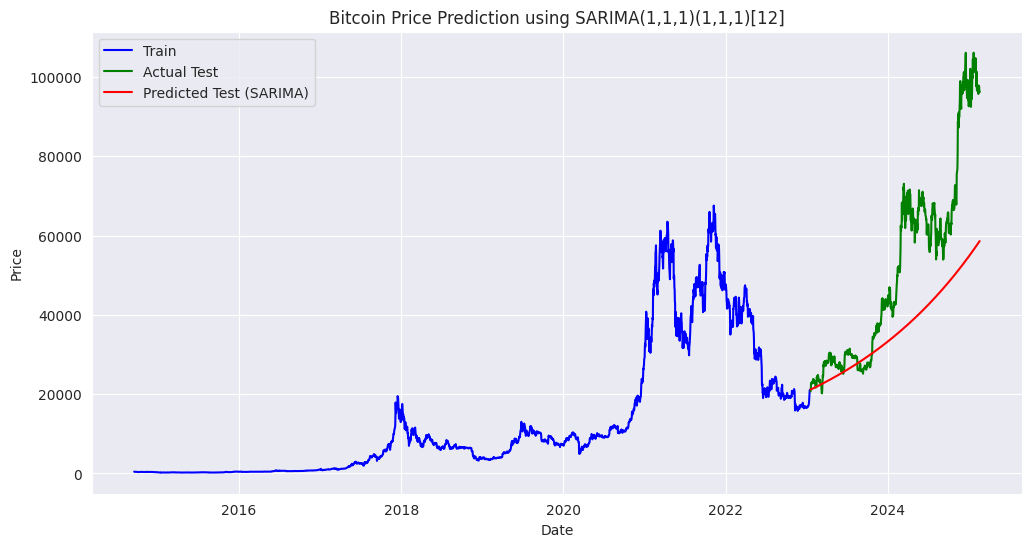

In [41]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close_SARIMA'], label="Predicted Test (SARIMA)", color='red')
plt.title("Bitcoin Price Prediction using SARIMA(1,1,1)(1,1,1)[12]")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## Hyperparameter Tuning

### Auto ARIMA for Best Parameters

In [42]:
auto_model = pm.auto_arima(
    train['Log_Close'],
    seasonal=True,
    m=12,                    # seasonal period (e.g., monthly seasonality)
    trace=True,              # print search process
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True            # use a stepwise algorithm to reduce computation time
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-11162.679, Time=7.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-11172.834, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-11170.010, Time=0.95 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-11169.992, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-11171.591, Time=0.27 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-11171.022, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-11171.020, Time=3.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-11169.545, Time=2.26 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-11171.831, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-11171.814, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-11169.857, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 19.478 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   

In [43]:
# Extract the best orders found by auto_arima
order = auto_model.order             # e.g., (p, d, q)
seasonal_order = auto_model.seasonal_order  # e.g., (P, D, Q, m)
print(f"Optimal Order: {order}")
print(f"Optimal Seasonal Order: {seasonal_order}")

Optimal Order: (0, 1, 0)
Optimal Seasonal Order: (0, 0, 0, 12)


In [44]:
# Step 2: Fit the SARIMAX model with the tuned parameters on the training data
improved_sarima_model = SARIMAX(
    train['Log_Close'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
improved_sarima_fit = improved_sarima_model.fit(disp=False)
print(improved_sarima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 3045
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5586.330
Date:                Mon, 17 Feb 2025   AIC                         -11170.660
Time:                        09:21:00   BIC                         -11164.639
Sample:                    09-17-2014   HQIC                        -11168.496
                         - 01-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0015   1.51e-05     98.655      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):             15415.16
Prob(Q):                              0.29   Pr

In [45]:
# Step 3: Forecast for the test period (forecast is on the log scale)
improved_forecast = improved_sarima_fit.forecast(steps=len(test))

In [46]:
# Step 4: Convert forecasted values back from log scale to original scale
test['Improved_Predicted_Close_SARIMA'] = np.exp(improved_forecast)

In [47]:
# Step 5: Evaluate the improved model's performance
mae_improved = mean_absolute_error(test['Close'], test['Improved_Predicted_Close_SARIMA'])
mse_improved = mean_squared_error(test['Close'], test['Improved_Predicted_Close_SARIMA'])
rmse_improved = np.sqrt(mse_improved)

print(f"Improved SARIMA MAE: {mae_improved:.2f}")
print(f"Improved SARIMA MSE: {mse_improved:.2f}")
print(f"Improved SARIMA RMSE: {rmse_improved:.2f}")

Improved SARIMA MAE: 30186.72
Improved SARIMA MSE: 1495269500.43
Improved SARIMA RMSE: 38668.71


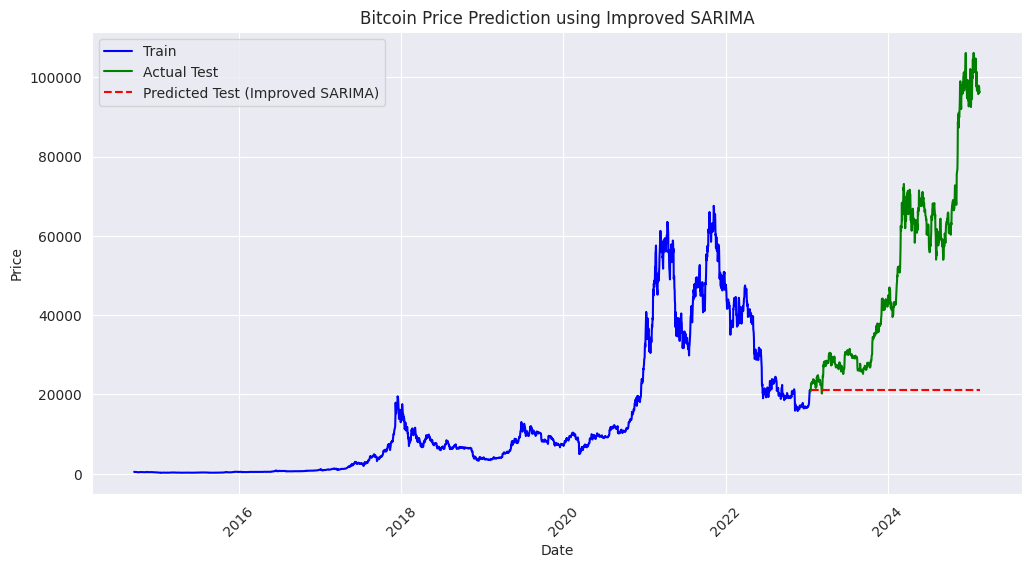

In [48]:
# Step 6: Plot the results for visual inspection
plt.figure(figsize=(12, 6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Improved_Predicted_Close_SARIMA'], label="Predicted Test (Improved SARIMA)", color='red', linestyle="dashed")
plt.title("Bitcoin Price Prediction using Improved SARIMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()